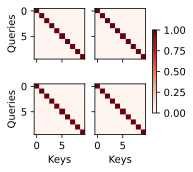

In [3]:
from utils import show_attention_heatmaps
import torch
attention_weight_first = torch.eye(10).reshape((1, 1, 10, 10))
attention_weight_second = torch.eye(10).reshape((1, 1, 10, 10))
attention_weight_third = torch.eye(10).reshape((1, 1, 10, 10))
attention_weight_fourth = torch.eye(10).reshape((1, 1, 10, 10))
attention_weights_row_one = torch.cat((attention_weight_first,attention_weight_second), dim=1)
attention_weights_row_two = torch.cat((attention_weight_third,attention_weight_fourth), dim=1)
attention_weights = torch.cat((attention_weights_row_one,attention_weights_row_two), dim=0)
show_attention_heatmaps(attention_weights, xlabel='Keys', ylabel='Queries')

# Nadaraya-Watson Estimator

The roots of attention goes up to Nadaraya-Watson Estimator, which is a non-parametric kernel regression method. In this method we have similarity function, namely kernel which measures similarity between query and key. 

Gaussian Kernel : $\alpha(k,q)= \exp(-\frac{||k-q||^2}{2})$


Boxcar Kernel : $\alpha(k,q)= 1    \ if ||k-q|| < 1$ 


Epanechikov Kernel : $\alpha(k,q)= max(1-{||k-q||},0)$

All of them goes to following equation



$f(q) = \sum_{i=1}^{m} v_i \frac{\alpha(k_i,q)}{\sum_{j=1}^{m} \alpha(k_j,q)}$

where k_i = x_i, v_i = y_i and q will be point to predict. With this we dont need to train.

Let's generate some data from this function: 

f(x) = $2 * sin(x) + x +  random()$

In [1]:
# Define the kernels
import torch 
import numpy as np

def Gaussian(x):
    return torch.exp(-x**2 / 2)

def BoxCar(x):
    return torch.abs(x) < 1

def Constant(x):
    return torch.ones_like(x)

def Epanechikov(x):
    return torch.max(1 - torch.abs(x), torch.zeros_like(x))

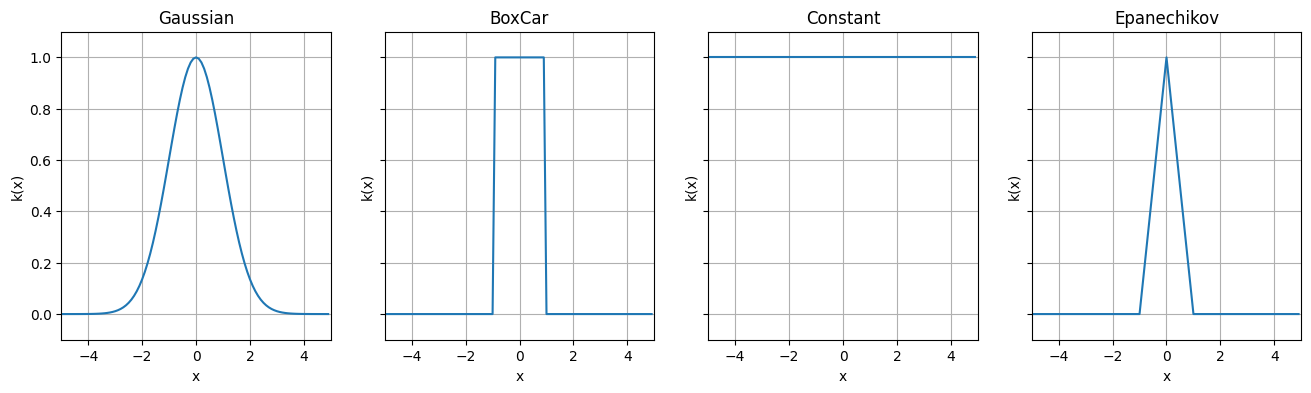

In [3]:
import matplotlib.pyplot as plt

fig,axes = plt.subplots(1,4,figsize=(16,4), sharex=True, sharey=True, squeeze=False)

kernels = (Gaussian, BoxCar, Constant, Epanechikov)
kernel_names = ['Gaussian', 'BoxCar', 'Constant', 'Epanechikov']

for kernel, kernel_name, ax in zip(kernels, kernel_names, axes[0]):
    ax.plot(torch.arange(-5,5,0.1).numpy(),kernel(torch.arange(-5,5,0.1)))
    ax.set_title(kernel_name)
    ax.set_xlabel('x')
    ax.set_ylabel('k(x)')
    ax.set_ylim(-0.1,1.1)
    ax.set_xlim(-5,5)
    ax.grid()

plt.show()


In [57]:
## Generate Data
def f(x):
    return 2 * torch.sin(x) + x
n = 40
x_train, _ = torch.sort(torch.rand(n) * 5)
y_train = f(x_train) + torch.randn(n)
x_val = torch.arange(0, 5, 0.1)
y_val = f(x_val)

In [58]:
dists = x_train.reshape(1, -1) - x_val.reshape(-1,1)
diff = dists[0].to(dtype=torch.float32) # must equal to each element of x_train - x_val[0]
torch.equal(diff, x_train - x_val[0])

dists / dists.sum(dim=1).reshape(-1,1)

tensor([[ 0.0003,  0.0023,  0.0028,  ...,  0.0454,  0.0462,  0.0478],
        [-0.0007,  0.0014,  0.0019,  ...,  0.0462,  0.0470,  0.0487],
        [-0.0018,  0.0004,  0.0009,  ...,  0.0471,  0.0480,  0.0497],
        ...,
        [ 0.0551,  0.0526,  0.0520,  ...,  0.0002, -0.0007, -0.0027],
        [ 0.0537,  0.0514,  0.0508,  ...,  0.0013,  0.0004, -0.0014],
        [ 0.0525,  0.0502,  0.0497,  ...,  0.0023,  0.0015, -0.0003]])

In [91]:
def nadaraya_watson(x_train,y_train,x_val,kernel):
    dists = x_train.reshape(1, -1) - x_val.reshape(-1,1)
    kernel_weights = kernel(dists).type(torch.float32)
    kernel_weights = kernel_weights / kernel_weights.sum(dim=1).reshape(-1,1)
    y_hat = kernel_weights @ y_train
    return y_hat, kernel_weights

def nadaraya_watson_with_sigma(x_train,y_train,x_val,kernel,sigma):
    dists = x_train.reshape(1, -1) - x_val.reshape(-1,1)
    kernel_weights = kernel(dists,sigma).type(torch.float32)
    kernel_weights = kernel_weights / kernel_weights.sum(dim=1).reshape(-1,1)
    y_hat = kernel_weights @ y_train
    return y_hat, kernel_weights
    

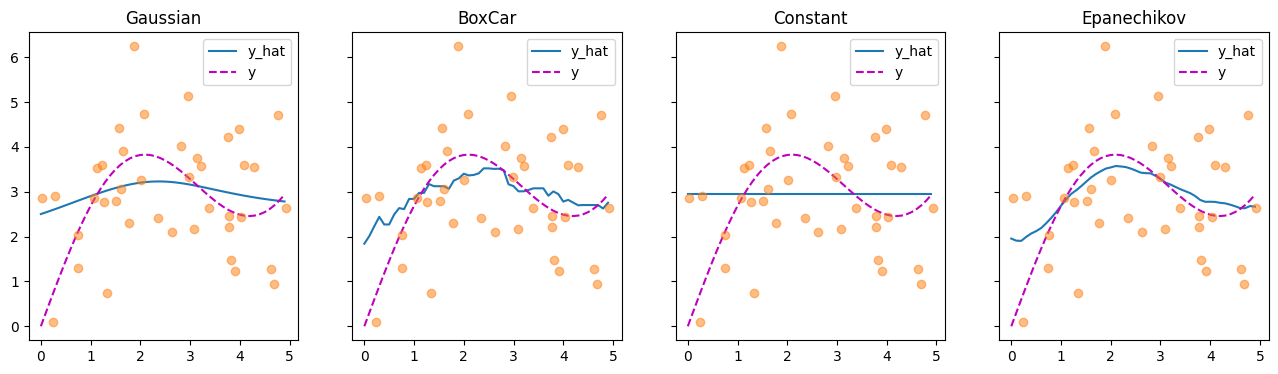

In [92]:
# Visualize predictions
fig,axes = plt.subplots(1,4, figsize=(16,4), sharey=True)
for kernel,kernel_name,ax in zip(kernels,kernel_names,axes):
    y_hat,_ = nadaraya_watson(x_train,y_train,x_val,kernel)
    ax.plot(x_val.numpy(), y_hat.numpy())
    ax.plot(x_val, y_val, 'm--')
    ax.plot(x_train, y_train, 'o', alpha=0.5)
    ax.set_title(kernel_name)
    ax.legend(['y_hat','y'])

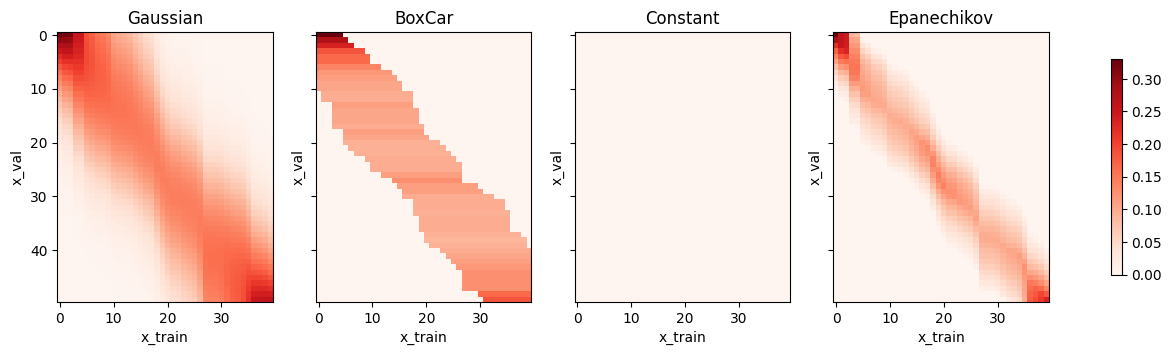

In [93]:
# Visualize Attention 
fig,axes = plt.subplots(1,4, figsize=(16,4), sharey=True)
for kernel,kernel_name,ax in zip(kernels,kernel_names,axes):
    _,attn = nadaraya_watson(x_train,y_train,x_val,kernel)
    pcm = ax.imshow(attn.detach().numpy(), cmap='Reds')
    ax.set_title(kernel_name)
    ax.set_xlabel('x_train')
    ax.set_ylabel('x_val')
    
fig.colorbar(pcm, ax=axes, shrink=0.7)


We can also change width of Gaussian kernel, this is called adapting

$\alpha(k,q)= \exp(-\frac{||k-q||^2}{2\sigma^2})$

Let's parametrize sigma and use SGD to find the best param for that

In [142]:
sigma = torch.tensor(0.5,requires_grad=True)

def GaussianWithSigma(x,sigma):
    return torch.exp(-(x ** 2) / (2*sigma**2))

def loss_fn(y,y_hat):
    return torch.sum((y-y_hat)**2)
    
optimizer = torch.optim.SGD([sigma],lr=0.01)

for i in range(1):
    y_hat, _ = nadaraya_watson_with_sigma(x_train=x_train,y_train=y_train,x_val=x_train,kernel=GaussianWithSigma,sigma=sigma)
    optimizer.zero_grad()
    loss = loss_fn(y_train,y_hat)
    loss.backward()
    optimizer.step()


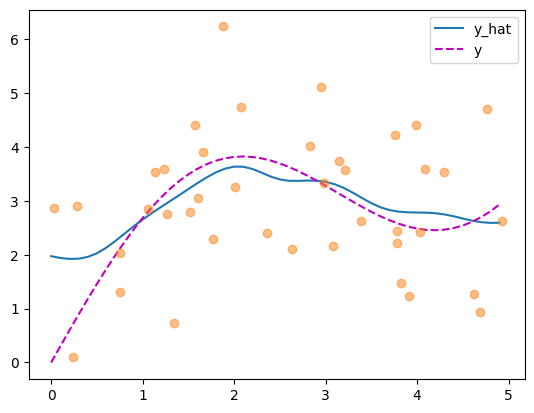

In [143]:
y_hat, _ = nadaraya_watson_with_sigma(x_train=x_train,y_train=y_train,x_val=x_val,kernel=GaussianWithSigma,sigma=sigma)
plt.plot(x_val.numpy(), y_hat.detach().numpy())
plt.plot(x_val.numpy(), y_val.numpy(), 'm--')
plt.plot(x_train.numpy(), y_train.numpy(), 'o', alpha=0.5)
plt.legend(['y_hat','y'])

## Masked Softmax



In [197]:
def sequence_mask_with_reshape(X, valid_len, value= -1e6):
    """ X is 2D array (number_of_points, maxlen), valid_len is 1D array (number_of_points)"""
    max_len = X.size(1)
    mask = torch.arange(max_len, dtype=torch.float32, device=X.device).reshape(1, -1) < valid_len.reshape(-1, 1)
    X[~mask] = value
    return X

def sequence_mask(X, valid_len, value= -1e6):
    """ X is 2D array (number_of_points, maxlen), valid_len is 1D array (number_of_points)"""
    max_len = X.size(1)
    # [None,: ] --> reshape to (1, max_len) --> broadcast to (number_of_points, max_len)
    mask = torch.arange(max_len, dtype=torch.float32, device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X


## These are all same but second one is hard to understand and little little bit faster

In [198]:
def masked_softmax(X, valid_lens):

    if valid_lens is None: 
        return torch.nn.functional.softmax(X, dim=-1)

    if valid_lens.dim() == 1:
        valid_lens = torch.repeat_interleave(valid_lens, X.shape[1])
    else:
        valid_lens = valid_lens.reshape(-1)
    

    masked_x = sequence_mask(X.reshape(-1, X.shape[-1]), valid_lens).reshape(X.shape)
    return torch.nn.functional.softmax(masked_x, dim=-1)
    
    
    

In [202]:
import math
class DotProductAttention(torch.nn.Module):
    def __init__(self, dropout: float = 0.1):
        super().__init__()
        self.dropout = torch.nn.Dropout(dropout)

    # size of queries (batch_size, n, d)
    # size of keys (batch_size, m, d)
    # size of values (batch_size, m,v)
    def forward(self, queries,keys,values,valid_lens=None):
        d = queries.shape[-1]
        mult = torch.bmm(queries, keys.transpose(1,2)) / math.sqrt(d) ## got (batch_size, n, m)
        self.attention_weights = masked_softmax(mult,valid_lens)
        return torch.bmm(self.dropout(self.attention_weights),values)

In [ ]:
queries = torch.normal(0, 1, (2, 1, 2))
keys = torch.normal(0, 1, (2, 10, 2))
values = torch.normal(0, 1, (2, 10, 4))
valid_lens = torch.tensor([2, 6])
attention = DotProductAttention(dropout=0.5)
attention.eval()
attention(queries, keys, values, valid_lens).shape  # must be (2,1,4)


torch.Size([2, 1, 4])

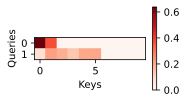

In [207]:
from utils import show_attention_heatmaps

show_attention_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),xlabel='Keys', ylabel='Queries')

## Let's implement Additive Attention

If the size of the query and key matrices are the same, we can use the dot product to calculate the attention weights but if they are different, we can use the additive attention.

$a(q,k) = W_v^T * tanh(W_q * q + W_k * k)$

We can write inside of tanh as single layer by concatenating q and k and W_q and W_k


In [ ]:
from torch import nn
class AdditiveAttention(nn.Module):
    def __init__(self, hidden_size, dropout=0.1):
        super().__init__()
        self.W_k = nn.LazyLinear(hidden_size,bias=False)
        self.W_q = nn.LazyLinear(hidden_size,bias=False)
        self.v = nn.LazyLinear(1,bias=False)
        self.dropout = nn.Dropout(dropout)
    
    """
    queries -- (batch_size,1,query_size)
    keys --  (batch_size,num_k,key_size)
    values -- (batch_size,num_k,value_size)
    """
    def forward(self,queries,keys,values,valid_lens=None):
        score = self.dropout(self.v(torch.tanh(self.W_q(queries) + self.W_k(keys))))
        self.attention_weights = masked_softmax(score,valid_lens) 
        return torch.bmm(self.attention_weights,values)
        

In [16]:
queries = torch.normal(0, 1, (2, 1, 2))
keys = torch.normal(0, 1, (2, 10, 2))
values = torch.normal(0, 1, (2, 10, 4))
W_k = nn.LazyLinear(5,bias=False)
W_q = nn.LazyLinear(5,bias=False)
v = nn.LazyLinear(1,bias=False)

v(torch.tanh(W_q(queries) + W_k(keys))).shape

torch.Size([2, 10, 1])